In [1]:
import os
import pickle
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np

HOME = os.environ["HOME"]
PICNIX = "pic-nix"

if PICNIX is not None:
    fullpath = os.sep.join([HOME, PICNIX, "script"])
    if os.path.exists(fullpath):
        sys.path.append(fullpath)
        print("Added {} to module search path".format(fullpath))
    else:
        print("Directory {} does not exist.".format(fullpath))

import shock

Added /home/amano/pic-nix/script to module search path


In [2]:
fn_reduced = "tbn80-u0025-bi100/reduce1d/reduce1d.h5"

with h5py.File(fn_reduced, "r") as fp:
    config = pickle.loads(fp["config"][()])
    xbine = fp["xbine"][()]
    t = fp["t"][()]
    x = fp["x"][()]
    E = fp["E"][()]
    B = fp["B"][()]
    Re = fp["Re"][()]
    Ve = fp["Ve"][()]
    Pe = fp["Pe"][()]

# by default, the last time step is selected
index = t.size - 1
index = 115

print(t.size, t[index])

for key, item in config["parameter"].items():
    print("{:10s} = {}".format(key, item))

140 31499.999999681862
taper      = 50.0
betai      = 1.0
betae      = 2.0
sigma      = 0.01
Nx         = 20640
Ny         = 1032
Nz         = 3
Cx         = 1720
theta      = 80.0
Cy         = 86
wp         = 1.0
Cz         = 1
Ns         = 2
delh       = 0.1
delt       = 0.05
nppc       = 32
mime       = 400
phi        = 0.0
u0         = 0.025


## Shock Speed in Simulation Frame

shock_position = [ 1.291e-02, -4.966e+01]


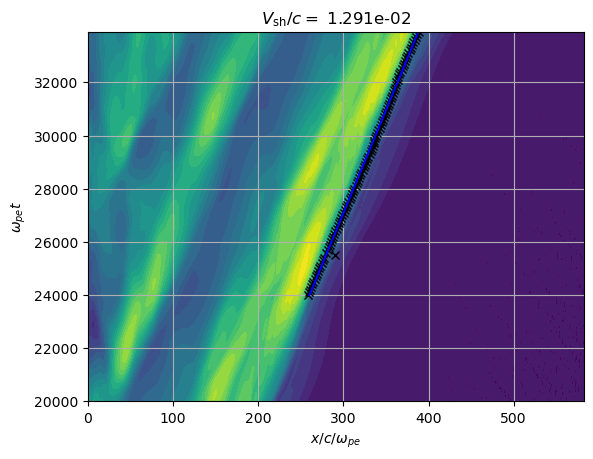

In [3]:
params = config["parameter"]
bx = B[..., 0]
by = B[..., 1]
bz = B[..., 2]
bb = np.sqrt(bx**2 + by**2 + bz**2)
T, X = np.meshgrid(x, t)

# calculate shock speed
steps = np.arange(t.size - 100, t.size)
t_sh, x_sh, v_sh, poly_sh = shock.calc_shock_speed(params, steps, t, x, bb, 0.01)

# plot for confirmation
plt.contourf(T, X, bb, 25)
plt.plot(x_sh, t_sh, "kx")
plt.plot(np.polyval(poly_sh, t_sh), t_sh, "b-")
plt.xlim(0, x_sh.max() * 1.5)
plt.ylim(t.min(), t.max())
plt.xlabel(r"$x / c/\omega_{pe}$")
plt.ylabel(r"$\omega_{pe} t$")
plt.grid()
plt.title(r"$V_{{\rm sh}}/c = ${:10.3e}".format(v_sh))

# print result
print("shock_position = [{:10.3e}, {:10.3e}]".format(poly_sh[0], poly_sh[1]))

## Cross-Shock Potential

(157.00653825366646, 557.0065382536665)

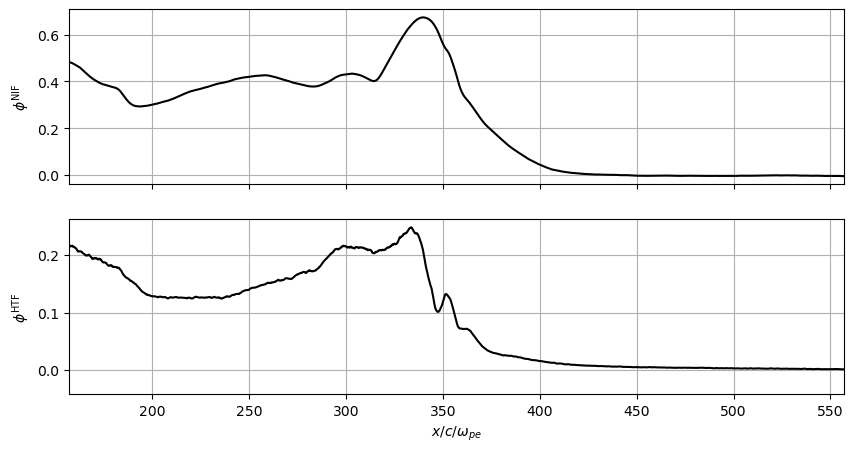

In [4]:
params = config["parameter"]
vars = {
    "x": x,
    "E": E[index],
    "B": B[index],
    "Re": Re[index],
    "Ve": Ve[index],
    "Pe": Pe[index],
}

# shock speed for normalization
v_sh_nif = v_sh + params["u0"]
xphi, phi_htf, phi_nif = shock.calc_shock_potential(params, v_sh_nif, vars)

# average upstream potential for zero level adjustment
x_peak = xphi[np.argmax(phi_nif)]
x_up1 = x_peak + 200
x_up2 = x_peak + 400
upstream_index = slice(*np.searchsorted(xphi, (x_up1, x_up2)))
phi_htf_zero = phi_htf[upstream_index].mean()
phi_nif_zero = phi_nif[upstream_index].mean()

# plot
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# NIF
plt.sca(axs[0])
plt.plot(xphi, phi_nif - phi_nif_zero, "k-")
plt.ylabel(r"$\phi^{\rm NIF}$")
plt.grid()

# HTF
plt.sca(axs[1])
plt.plot(xphi, phi_htf - phi_htf_zero, "k-")
plt.ylabel(r"$\phi^{\rm HTF}$")
plt.xlabel(r"$x / c/\omega_{pe}$")
plt.grid()

x_shock = np.polyval(poly_sh, t[index])
plt.xlim(max(x_shock - 200, 0), x_shock + 200)

## Energy Spectrum

In [5]:
def pcolormesh_args(xedges, yedges):
    x = 0.5 * (xedges[+1:] + xedges[:-1])
    y = 0.5 * (yedges[+1:] + yedges[:-1])
    X, Y = np.broadcast_arrays(x[:, None], y[None, :])
    return X, Y


def convert_to_momentum_spectrum(energy, dist):
    p = np.sqrt((energy + 1) ** 2 - 1)
    e2p = 1 / (4 * np.pi * p * np.sqrt(p**2 + 1))
    if dist.ndim == 1 and dist.size == p.size:
        return p, dist * e2p
    elif dist.ndim == 2 and dist.shape[1] == p.size:
        return p, dist * e2p[np.newaxis, :]
    else:
        raise ValueError("Invalid shape of distribution function.")


with h5py.File(fn_reduced, "r") as fp:
    config = pickle.loads(fp["config"][()])
    xbine = fp["xbine"][()]
    ubine = fp["ubine"][()]
    ebine = fp["ebine"][()]
    x = fp["x"][()]
    B = fp["B"][index, :, :]
    Ve = fp["Ve"][index, :, :]
    Ri = fp["Ri"][index, :]
    Vi = fp["Vi"][index, :, :]
    Re = fp["Re"][index, :]
    fux = fp["Feu"][index, :, :, 0]
    fuy = fp["Feu"][index, :, :, 1]
    fuz = fp["Feu"][index, :, :, 2]
    xbinc = 0.5 * (xbine[1:] + xbine[:-1])
    ebinc = 0.5 * (ebine[1:] + ebine[:-1])
    # count
    f_ene = fp["Feu"][index, :, :, 3]
    f_cnt = np.diff(xbine)[:, np.newaxis] * np.diff(ebine)[np.newaxis, :] * f_ene
    # momentum spectrum
    pbinc, f_mom = convert_to_momentum_spectrum(ebinc, f_ene)
    pbine = np.sqrt((ebine + 1) ** 2 - 1)

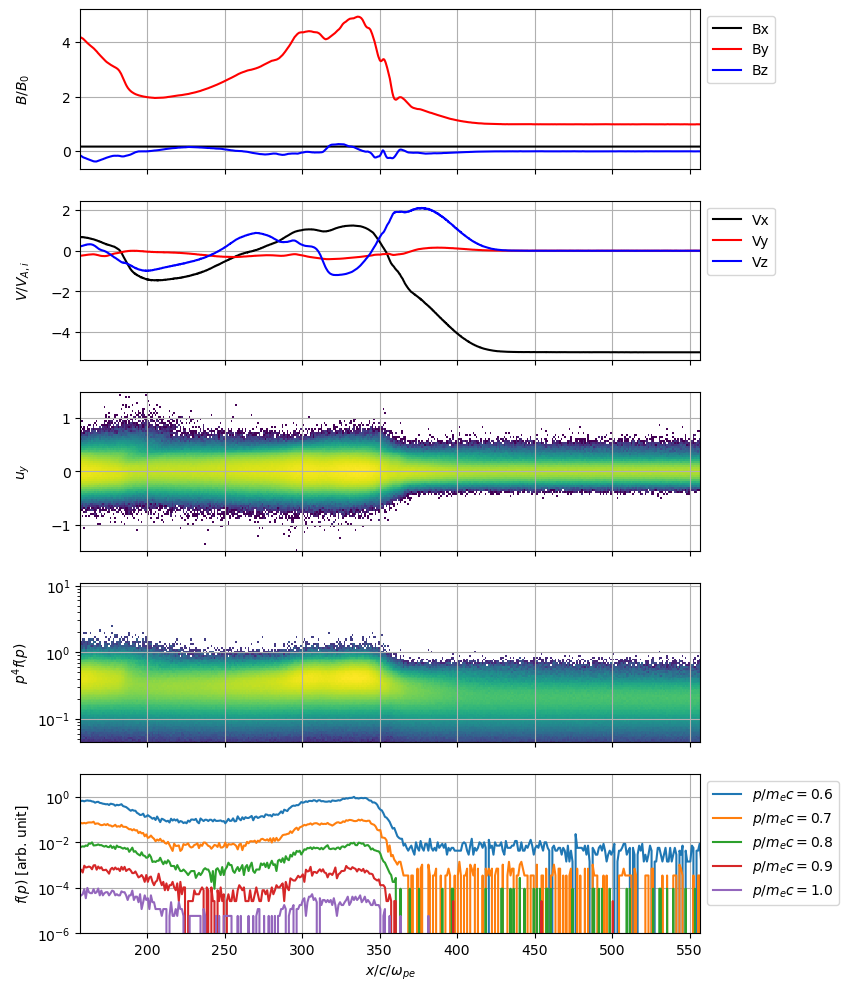

In [6]:
params = config["parameter"]
mime = params["mime"]
sigma = params["sigma"]
vae = np.sqrt(sigma)
vai = vae / np.sqrt(mime)
u0 = params["u0"]
b0 = np.sqrt(sigma) / np.sqrt(1 + u0**2)

fig, axs = plt.subplots(5, 1, figsize=(8, 12), sharex=True)

plt.sca(axs[0])
plt.plot(x, B[:,0] / b0, "k-", label="Bx")
plt.plot(x, B[:,1] / b0, "r-", label="By")
plt.plot(x, B[:,2] / b0, "b-", label="Bz")
plt.ylabel(r"$B / B_0$")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.sca(axs[1])
plt.plot(x, Vi[:,0] / vai, "k-", label="Vx")
plt.plot(x, Vi[:,1] / vai, "r-", label="Vy")
plt.plot(x, Vi[:,2] / vai, "b-", label="Vz")
plt.ylabel(r"$V / V_{A,i}$")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.sca(axs[2])
X, Y = pcolormesh_args(xbine, ubine)
plt.pcolormesh(X, Y, fuy, shading="nearest", norm=mpl.colors.LogNorm())
plt.ylabel(r"$u_y$")

plt.sca(axs[3])
X, Y = pcolormesh_args(xbine, pbine)
plt.pcolormesh(X, Y, f_mom * Y**4, shading="nearest", norm=mpl.colors.LogNorm())
plt.ylabel(r"$p^4 f(p)$")
plt.semilogy()

plt.sca(axs[4])
psample = [0.6, 0.7, 0.8, 0.9, 1.0]
pindex = np.searchsorted(pbine, psample)
for i in range(len(psample)):
    f_norm = f_mom[:,pindex[i]] / np.max(f_mom[:,pindex[i]])
    plt.plot(xbinc, f_norm * 10**(-i), label=r"$p/m_e c = {:.1f}$".format(psample[i]))
plt.ylabel(r"$f(p)$ [arb. unit]")
plt.semilogy()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(1.0e-6, 1.0e+1)
plt.xlim(max(x_shock - 200, 0), x_shock + 200)
plt.xlabel(r"$x / c / \omega_{pe}$")

for ax in axs:
    ax.grid(True)
# align y labels to the right
fig.align_ylabels(axs)

(0.1, 10000.0)

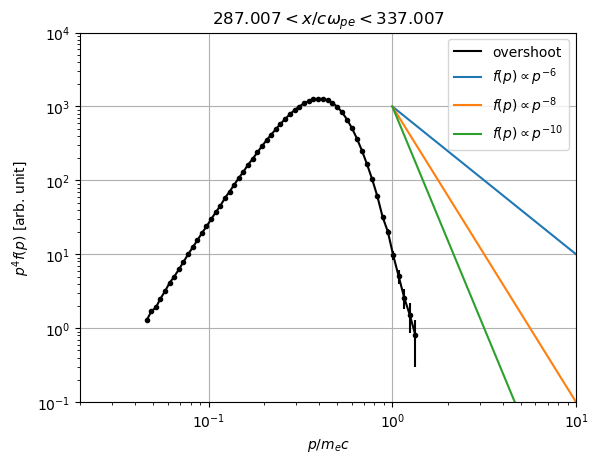

In [7]:
xmin = x_shock - 70
xmax = x_shock - 20
index1 = np.searchsorted(xbine, xmin)
index2 = np.searchsorted(xbine, xmax)
xindex = slice(index1, index2)
Nx = index2 - index1

# spectrum at overshoot
pval = pbinc
yval = f_mom[xindex, :].mean(axis=0) * pval**4
ycnt = f_cnt[xindex, :].sum(axis=0) + 1
yerr = np.sqrt(ycnt / Nx) / np.diff(ebine)
_, yerr = convert_to_momentum_spectrum(pval, yerr) * pval**4

plot_index = yval > yerr
plt.loglog(pval[plot_index], yval[plot_index], "k-", label="overshoot")
plt.errorbar(pval[plot_index], yval[plot_index], yerr=yerr[plot_index], fmt="k.")

# reference
colors = list(mpl.colors.TABLEAU_COLORS)
f0 = 1.0e3
pp = np.logspace(0, 1, 11) / 1.0e-0
plt.loglog(pp, f0 * pp ** (-2), color=colors[0], label=r"$f(p) \propto p^{-6}$")
plt.loglog(pp, f0 * pp ** (-4), color=colors[1], label=r"$f(p) \propto p^{-8}$")
plt.loglog(pp, f0 * pp ** (-6), color=colors[2], label=r"$f(p) \propto p^{-10}$")
plt.grid()

plt.title(r"${:10.3f} < x/c\omega_{{pe}} < {:10.3f}$".format(xmin, xmax))
plt.legend(loc="upper right")
plt.xlabel(r"$p / m_e c$")
plt.ylabel(r"$p^4 f(p)$ [arb. unit]")
plt.xlim(2e-2, 1e1)
plt.ylim(1e-1, 1e4)